In [1]:
import os
import sys
from math import fabs
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from pandas import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import requests
import json
import heapq

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, Activation, MaxPooling2D, BatchNormalization, Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import plot_model, to_categorical

import imp
import module as module

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.options.display.max_columns = 50

In [2]:
import tensorflow as tf
assert tf.__version__ == '2.0.0'
assert int(tf.__version__[0]) >= 2

# 1. Data loading, exploration and preparation

In [3]:
# ============
# Data loading
# ============

# Reading and writing parquet files:
# https://arrow.apache.org/docs/python/parquet.html

data_pq = pq.read_table('data.parquet') 
data = data_pq.to_pandas()
data.head()

uuid             cc3      color1  polka dot  \
0  004b8_xRpqDn3Gi7deWgA9dCFTSqUb  CASUAL_DRESSES     VARIOUS          0   
1  02089_tvXR6Kt1R735eMgjjLnrWdbY         BLOUSES       GREEN          0   
2  03f0a_uVchHbTLFTvsyaD69ZVP4Lhv       TANK_TOPS     VARIOUS          0   
3  03ce5_HnMQe5Aqimp8KLnyELn5kMvZ          SHIRTS  LIGHT-BLUE          0   
4  04057_39NFDsDVJJJ8FvZa7dHGZsB2  CASUAL_DRESSES       BLACK          0   

   floral  checker  
0       0        0  
1       1        0  
2       1        0  
3       0        0  
4       1        0

In [4]:
test_pq = pq.read_table('test.parquet')
test_pd = test_pq.to_pandas()
test_pd.head()

uuid
0  01214_HahXniyBFwRjdgv1Z2GtTN4y
1  005ce_nRriUxiS8iyLBW5ipdem5CrA
2  020b8_1um37vo4nagrTUrPaMnvhXbK
3  033cd_7e58vR1T9vW2R7pnSDNUhLoK
4  00f4a_ntveDEhQknB7cohthb4eeHd8

In [5]:
example_predictions_pq = pq.read_table('example_predictions.parquet')
example_predictions = example_predictions_pq.to_pandas()
example_predictions.head()

uuid  category1  category2  polka dot  floral  \
0  01214_HahXniyBFwRjdgv1Z2GtTN4y          0          2          1       0   
1  005ce_nRriUxiS8iyLBW5ipdem5CrA          2          0          1       0   
2  020b8_1um37vo4nagrTUrPaMnvhXbK          3          1          1       1   
3  033cd_7e58vR1T9vW2R7pnSDNUhLoK          2          4          1       0   
4  00f4a_ntveDEhQknB7cohthb4eeHd8          3          2          1       0   

   checker  
0        1  
1        1  
2        1  
3        0  
4        1

In [6]:
len(data), len(test_pd), len(example_predictions)

(3547, 429, 429)

In [7]:
# ==========================
# Main parameters of project (ideally this should be read from a configuration file)
# ==========================

pwd = os.getcwd()

# the files are compressed to 0.7 their original size
height, width = 224,224 #301, 217 
columns_tags=['polka dot', 'floral', 'checker']
#columns_cc3 programmatically defined from cc3 column

# the data type selected for tf.keras model: float16
keras_float_type_selected = 'float16'

# downsampling of cc3 classes towards the lowest number class
data_balanced = False

In [8]:
# ================================
# ENCODING OF CATEGORICAL FEATURES
# ================================

# a. Label encoding of cc3 and color1

categorical_target = ['cc3','color1']
categorical_target_encoders = []

le_dico = {}
for item in categorical_target:
    le = LabelEncoder()
    le.fit(data[item])
    data[item+'_le'] = le.transform(data[item])
    print(item, le.classes_, le.transform(le.classes_), le.inverse_transform(le.transform(le.classes_)) ) #le.classes_ gives the unique values
    print()
    categorical_target_encoders.append(le)
    le_dico[item] = le

data.head(10) 

cc3 ['BLOUSES' 'CASUAL_DRESSES' 'MINI_DRESSES' 'SHIRTS' 'TANK_TOPS'] [0 1 2 3 4] ['BLOUSES' 'CASUAL_DRESSES' 'MINI_DRESSES' 'SHIRTS' 'TANK_TOPS']

color1 ['BLACK' 'BLUE' 'BODY' 'BROWN' 'BURGUNDY' 'CORAL' 'CREAM' 'DARK-GREEN'
 'GOLD' 'GREEN' 'GREY' 'KHAKI' 'LIGHT-BLUE' 'LILAC' 'MINT' 'MUSTARD'
 'NAVY' 'ORANGE' 'PINK' 'PURPLE' 'RED' 'ROSE' 'SILVER' 'TURQUOISE'
 'VARIOUS' 'WHITE' 'YELLOW'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] ['BLACK' 'BLUE' 'BODY' 'BROWN' 'BURGUNDY' 'CORAL' 'CREAM' 'DARK-GREEN'
 'GOLD' 'GREEN' 'GREY' 'KHAKI' 'LIGHT-BLUE' 'LILAC' 'MINT' 'MUSTARD'
 'NAVY' 'ORANGE' 'PINK' 'PURPLE' 'RED' 'ROSE' 'SILVER' 'TURQUOISE'
 'VARIOUS' 'WHITE' 'YELLOW']



uuid             cc3      color1  polka dot  \
0  004b8_xRpqDn3Gi7deWgA9dCFTSqUb  CASUAL_DRESSES     VARIOUS          0   
1  02089_tvXR6Kt1R735eMgjjLnrWdbY         BLOUSES       GREEN          0   
2  03f0a_uVchHbTLFTvsyaD69ZVP4Lhv       TANK_TOPS     VARIOUS          0   
3  03ce5_HnMQe5Aqimp8KLnyELn5kMvZ          SHIRTS  LIGHT-BLUE          0   
4  04057_39NFDsDVJJJ8FvZa7dHGZsB2  CASUAL_DRESSES       BLACK          0   
5  016d6_YQLmwZ6Bd5j111jrpwuS32Lf       TANK_TOPS        BLUE          1   
6  00ee8_3hboMf2ssLCcEeRVBojqP1c2  CASUAL_DRESSES        BLUE          0   
7  00820_X6Y7Dgvomz4LpApPS7mVGxEC         BLOUSES       WHITE          1   
8  03548_tPCALYeSoddrydoVwfiWiyfk         BLOUSES       BLACK          1   
9  024c7_K2J16Ry4tKLubWhNzoduZU9v       TANK_TOPS     VARIOUS          0   

   floral  checker  cc3_le  color1_le  
0       0        0       1         24  
1       1        0       0          9  
2       1        0       4         24  
3       0        0       3         12  
4       1        0       1          0  
5       0        0       4          1  
6       0        0       1          1  
7       0        0       0         25  
8       0        0       0          0  
9       1        0       4         24

In [9]:
#b. Categorical encoding of cc3

dd = to_categorical(data['cc3_le'],num_classes=5).astype(int)
le = le_dico['cc3']
columns_cc3 = le.inverse_transform([0,1,2,3,4]).tolist()
columns_cc3 = [x.lower() for x in columns_cc3]
dd_pd = pd.DataFrame(dd,columns=columns_cc3)

data = pd.concat([data,dd_pd], axis=1) 
data.head(10)

uuid             cc3      color1  polka dot  \
0  004b8_xRpqDn3Gi7deWgA9dCFTSqUb  CASUAL_DRESSES     VARIOUS          0   
1  02089_tvXR6Kt1R735eMgjjLnrWdbY         BLOUSES       GREEN          0   
2  03f0a_uVchHbTLFTvsyaD69ZVP4Lhv       TANK_TOPS     VARIOUS          0   
3  03ce5_HnMQe5Aqimp8KLnyELn5kMvZ          SHIRTS  LIGHT-BLUE          0   
4  04057_39NFDsDVJJJ8FvZa7dHGZsB2  CASUAL_DRESSES       BLACK          0   
5  016d6_YQLmwZ6Bd5j111jrpwuS32Lf       TANK_TOPS        BLUE          1   
6  00ee8_3hboMf2ssLCcEeRVBojqP1c2  CASUAL_DRESSES        BLUE          0   
7  00820_X6Y7Dgvomz4LpApPS7mVGxEC         BLOUSES       WHITE          1   
8  03548_tPCALYeSoddrydoVwfiWiyfk         BLOUSES       BLACK          1   
9  024c7_K2J16Ry4tKLubWhNzoduZU9v       TANK_TOPS     VARIOUS          0   

   floral  checker  cc3_le  color1_le  blouses  casual_dresses  mini_dresses  \
0       0        0       1         24        0               1             0   
1       1        0       0          9        1               0             0   
2       1        0       4         24        0               0             0   
3       0        0       3         12        0               0             0   
4       1        0       1          0        0               1             0   
5       0        0       4          1        0               0             0   
6       0        0       1          1        0               1             0   
7       0        0       0         25        1               0             0   
8       0        0       0          0        1               0             0   
9       1        0       4         24        0               0             0   

   shirts  tank_tops  
0       0          0  
1       0          0  
2       0          1  
3       1          0  
4       0          0  
5       0          1  
6       0          0  
7       0          0  
8       0          0  
9       0          1

[]

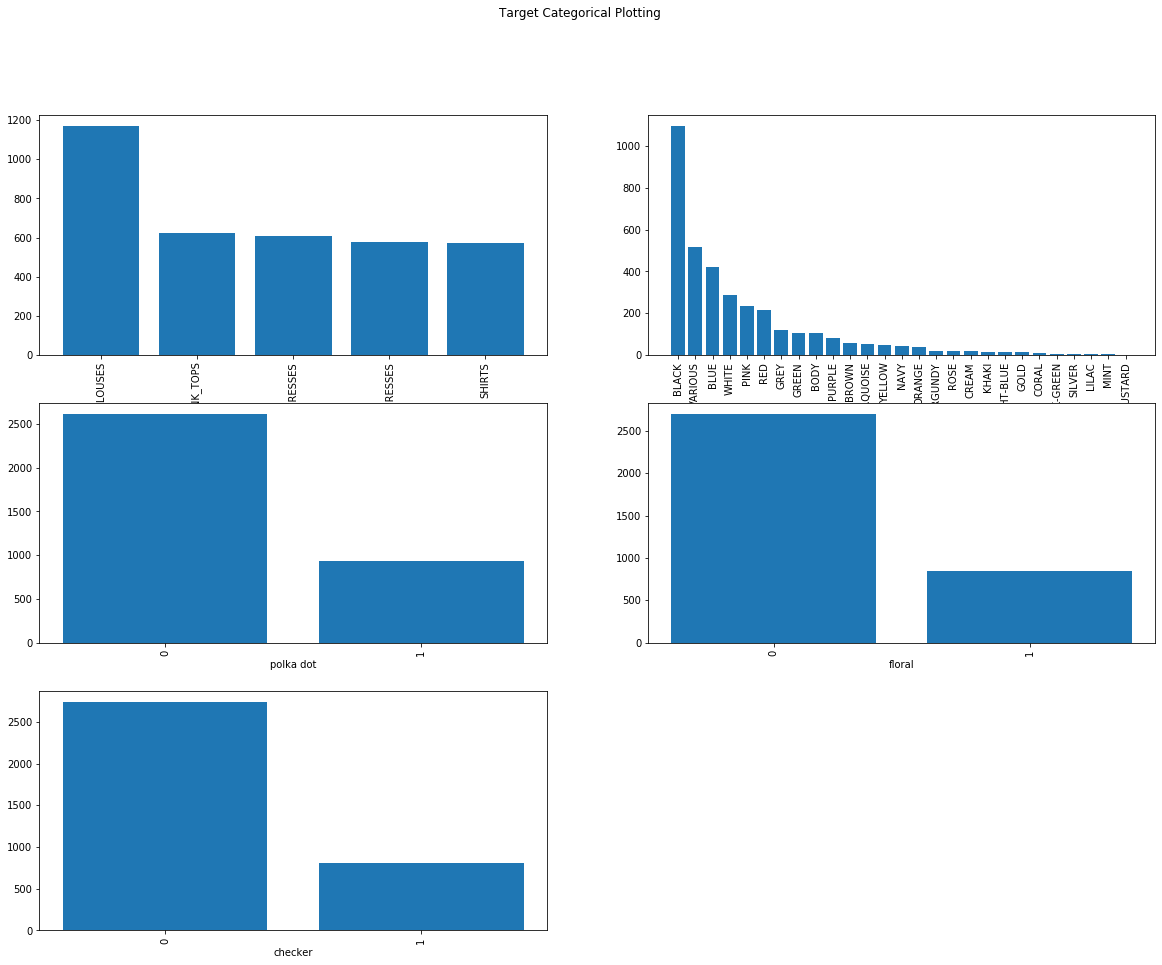

In [10]:
# ===============================
# Basic exploratory data analysis
# ===============================

# Let's plot the distributions of 
# - the different classes of cc3
# - the different colors
# - the 3 different tag labels

fig, axs = plt.subplots(1, 2, figsize=(20, 15), sharey=False)
fig.suptitle('Target Categorical Plotting')

for i,column in enumerate(['cc3', 'color1', 'polka dot', 'floral', 'checker']):
    ax1 = plt.subplot(3,2,i+1)
    items = data[column].value_counts().index.tolist()
    values = data[column].value_counts().values.tolist()
    ax1.bar(items, values)
    y_pos = range(len(items))
    plt.xticks(y_pos, items, rotation=90)
    ax1.set_xlabel(column)

plt.plot()

<Figure size 432x288 with 0 Axes>

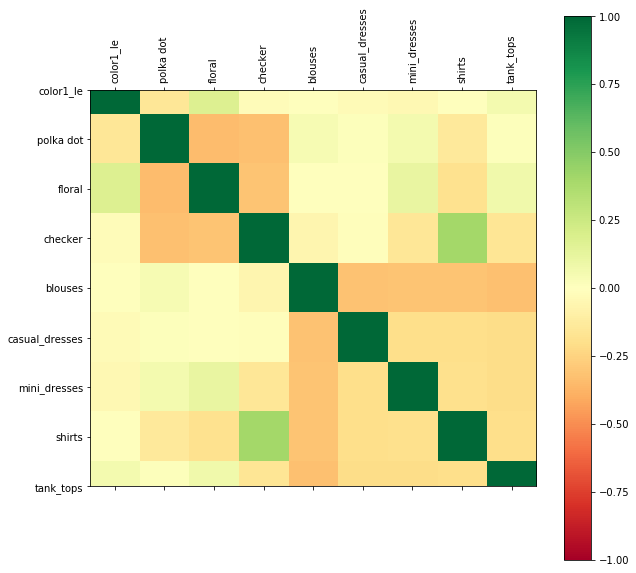

field vs field  correlation
9                checker vs shirts         0.40
3              floral vs polka dot        -0.34
6             checker vs polka dot        -0.33
11       blouses vs casual_dresses        -0.32
14            blouses vs tank_tops        -0.32
7                checker vs floral        -0.31
12         blouses vs mini_dresses        -0.31
13               blouses vs shirts        -0.31
17     casual_dresses vs tank_tops        -0.21
20             shirts vs tank_tops        -0.20
16        casual_dresses vs shirts        -0.20
19       mini_dresses vs tank_tops        -0.20
15  casual_dresses vs mini_dresses        -0.20
18          mini_dresses vs shirts        -0.19
5                 floral vs shirts        -0.19
1              color1_le vs floral         0.18
0           color1_le vs polka dot        -0.16
10            checker vs tank_tops        -0.16
8          checker vs mini_dresses        -0.15
2              polka dot vs shirts        -0.13
4           floral vs mini_dresses         0.11

In [11]:
# =========================================
# Inspection of correlations between labels
# =========================================

# The idea is to see if there exist significant correlations between cc3 classes and tags labels. 
# For example, the "checker vs shirts" shows that there might be a benefit to use a multi-task model over 2 disjoined models (one for cc3, one for tags). 
# The multi-task model would take advantage of such correlation. 

imp.reload(module)

feature_cols= ['color1_le', 'polka dot', 'floral', 'checker'] + columns_cc3

corr,df_corr_sorted = module.Get_and_Plot_correlations(data[feature_cols], size=10, min_cor=0.1)
df_corr_sorted[['field vs field','correlation']]

In [12]:
# ====================================================================
# Balancing the dataset to have similar number of samples in cc3 class
# ====================================================================

imp.reload(module)

if data_balanced: #downsampling toward the lowest class
    data_balanced = module.downsample(data, 'cc3', random_state=42)
else:
    data_balanced = data.copy() #no downsampling

print('Size of balanced dataframe: ', len(data_balanced))
print()
print(data_balanced['cc3'].value_counts())
data_balanced.head()   

Size of balanced dataframe:  3547

BLOUSES           1168
TANK_TOPS          624
CASUAL_DRESSES     607
MINI_DRESSES       577
SHIRTS             571
Name: cc3, dtype: int64


uuid             cc3      color1  polka dot  \
0  004b8_xRpqDn3Gi7deWgA9dCFTSqUb  CASUAL_DRESSES     VARIOUS          0   
1  02089_tvXR6Kt1R735eMgjjLnrWdbY         BLOUSES       GREEN          0   
2  03f0a_uVchHbTLFTvsyaD69ZVP4Lhv       TANK_TOPS     VARIOUS          0   
3  03ce5_HnMQe5Aqimp8KLnyELn5kMvZ          SHIRTS  LIGHT-BLUE          0   
4  04057_39NFDsDVJJJ8FvZa7dHGZsB2  CASUAL_DRESSES       BLACK          0   

   floral  checker  cc3_le  color1_le  blouses  casual_dresses  mini_dresses  \
0       0        0       1         24        0               1             0   
1       1        0       0          9        1               0             0   
2       1        0       4         24        0               0             0   
3       0        0       3         12        0               0             0   
4       1        0       1          0        0               1             0   

   shirts  tank_tops  
0       0          0  
1       0          0  
2       0          1  
3       1          0  
4       0          0

In [13]:
# ==============================================
# Adding file format to file names in dataframes
# ==============================================

def append_ext(fn):
    return fn+".jpeg"

data_balanced["uuid"] = data_balanced["uuid"].apply(append_ext)

test_pd["uuid"] = test_pd["uuid"].apply(append_ext)

example_predictions["uuid"] = example_predictions["uuid"].apply(append_ext)

data_balanced.head()

uuid             cc3      color1  polka dot  \
0  004b8_xRpqDn3Gi7deWgA9dCFTSqUb.jpeg  CASUAL_DRESSES     VARIOUS          0   
1  02089_tvXR6Kt1R735eMgjjLnrWdbY.jpeg         BLOUSES       GREEN          0   
2  03f0a_uVchHbTLFTvsyaD69ZVP4Lhv.jpeg       TANK_TOPS     VARIOUS          0   
3  03ce5_HnMQe5Aqimp8KLnyELn5kMvZ.jpeg          SHIRTS  LIGHT-BLUE          0   
4  04057_39NFDsDVJJJ8FvZa7dHGZsB2.jpeg  CASUAL_DRESSES       BLACK          0   

   floral  checker  cc3_le  color1_le  blouses  casual_dresses  mini_dresses  \
0       0        0       1         24        0               1             0   
1       1        0       0          9        1               0             0   
2       1        0       4         24        0               0             0   
3       0        0       3         12        0               0             0   
4       1        0       1          0        0               1             0   

   shirts  tank_tops  
0       0          0  
1       0          0  
2       0          1  
3       1          0  
4       0          0

# 2. Multi-task Modelling

The model is a 2-task model:

* The task 1 is a multi-class classification of the cc3 classes. The output for this task (see function transfer_learning_model) is a dense(5) layer, to be matched with a one-hot-encoded version of the cc3 columns (containing 5 classes). As it is a multi-class problem, the loss function for that task is a softmax, i.e., the probabilities of all classes sum to 1.

* The task 2 is a multi-label classification of the polka dot, floral, checker columns. The output for this task (see function transfer_learning_model) is a dense(3) layer, to be matched with these 3 columns (already in one-hot-encoded format). As it is a multi-label problem, the loss function for that task is a sigmoid, i.e., the probabilities for each label is independent from the other labels.      

It is a transfer-learning model. It is composed of a convolutional base (VGG16 net), and a dense output for each task. 

It is using the tf.keras api, as it has become the standard go-to from TF 2.0

In [14]:
# ================================
# Model definition and preparation
# ================================

# Task 1: classification of one class of clothes among 5; a typical multi-class task
# Task 2: detection of 3 potential tags; a typical multi-label task

# Great resources:
#https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
#https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
# multi-class vs multi-output: simple description: https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/
#fashion_mnist: https://www.tensorflow.org/tutorials/keras/classification

imp.reload(module)

tf.keras.backend.clear_session()  # For easy reset of notebook state.
tf.keras.backend.set_floatx(keras_float_type_selected) # some doc on float16: https://github.com/tensorflow/tensorflow/issues/34406

columns = columns_cc3 + columns_tags

# Training data will be augmented
datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode='nearest',
                           dtype = keras_float_type_selected)

# Note that the validation and test data should not be augmented!
test_datagen=ImageDataGenerator(rescale=1./255.,
                                dtype = keras_float_type_selected)

#don't forget to shuffle the df rows for train and validation, to be sure we don't include any weird trend
train_generator=datagen.flow_from_dataframe(
    dataframe=data_balanced[:2800], #[:2300], 
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=columns,
    batch_size=50,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(height,width))

valid_generator=test_datagen.flow_from_dataframe(  # Here: not using augmentation in validation set
    dataframe=data_balanced[2800:3100], #[2300:2600],   
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=columns,
    batch_size=25,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(height,width))

heldout_generator=test_datagen.flow_from_dataframe(
    dataframe=data_balanced[3100:], #[2600:],   
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=None, 
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None, 
    target_size=(height,width))

inference_generator=test_datagen.flow_from_dataframe(
    dataframe=test_pd,
    directory=pwd+'/data/',
    x_col="uuid",
    y_col=None,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(height,width))

model = module.transfer_learning_model(height,width,fine_tuning=False)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)


model.compile(optimizer = opt, 
              loss = {'cc3':"categorical_crossentropy",
                      'tags':"binary_crossentropy"}, 
              loss_weights = {'cc3': 1,'tags': 1.}, 
              metrics = ["accuracy"])

callbacks = [EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min'),
             ModelCheckpoint(filepath='./model_training/tf_keras_model/model-epoch{epoch:02d}-cc3_loss{cc3_loss:.4f}-tags_loss{tags_loss:.4f}-val_cc3_acc{val_cc3_accuracy:.2f}-val_tags_acc{val_tags_accuracy:.2f}.h5',
                             monitor='val_loss',
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             verbose=1),
             CSVLogger('training_{0}.log'.format('vgg19'),
                       separator=',',
                       append=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
             TerminateOnNaN()
            ]

def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,0:5],batch_y[:,5:8]])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_HELDOUT=heldout_generator.n//heldout_generator.batch_size
STEP_SIZE_INFERENCE=inference_generator.n//inference_generator.batch_size

Found 2800 validated image filenames.
Found 300 validated image filenames.
Found 447 validated image filenames.
Found 429 validated image filenames.

If you intended to run this layer in float16, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



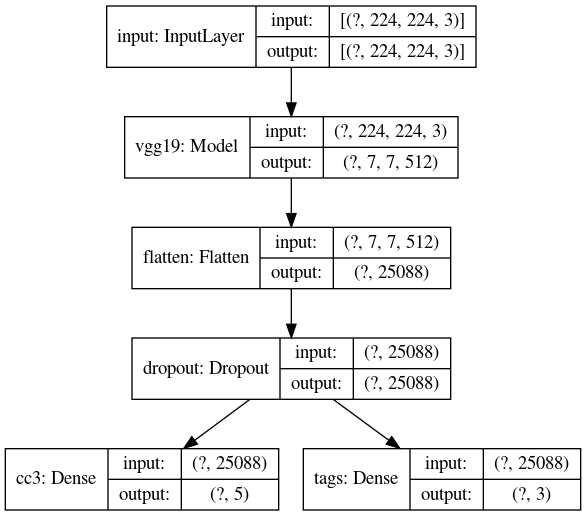

In [16]:
# ===============
# Model structure
# ===============

plot_model(model, to_file='./model_training/tf_keras_model/model.png', show_shapes=True)
plot_model(model, show_shapes=True)

In [17]:
with open('./model_training/tf_keras_model/model_summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
model.summary()    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Model)                   (None, 7, 7, 512)    20024384    input[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 25088)        0           vgg19[1][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 25088)        0           flatten[0][0]                    
______________________________________________________________________________________________

In [18]:
# =============
# MAIN TRAINING ("Feature extraction")
# =============

# following https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
history = model.fit_generator(generator=generator_wrapper(train_generator),
                              class_weight = {'cc3': [1.,1.,1.,1.,1.],'tags': [1.,1.,1.]},
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=generator_wrapper(valid_generator),
                              validation_steps=STEP_SIZE_VALID,
                              epochs=60,
                              callbacks=callbacks,
)

Epoch 1/60
55/56 [============================>.] - ETA: 1s - loss: 2.1414 - cc3_loss: 1.6191 - tags_loss: 0.5234 - cc3_accuracy: 0.3108 - tags_accuracy: 0.7573
Epoch 00001: saving model to ./model_training/tf_keras_model/model-epoch01-cc3_loss1.6162-tags_loss0.5229-val_cc3_acc0.46-val_tags_acc0.80.h5
56/56 [==============================] - 86s 2s/step - loss: 2.1377 - cc3_loss: 1.6162 - tags_loss: 0.5229 - cc3_accuracy: 0.3127 - tags_accuracy: 0.7578 - val_loss: 1.7778 - val_cc3_loss: 1.3555 - val_tags_loss: 0.4231 - val_cc3_accuracy: 0.4568 - val_tags_accuracy: 0.8032
Epoch 2/60
55/56 [============================>.] - ETA: 1s - loss: 1.9021 - cc3_loss: 1.4600 - tags_loss: 0.4434 - cc3_accuracy: 0.3728 - tags_accuracy: 0.7920
Epoch 00002: saving model to ./model_training/tf_keras_model/model-epoch02-cc3_loss1.4580-tags_loss0.4431-val_cc3_acc0.49-val_tags_acc0.84.h5
56/56 [==============================] - 77s 1s/step - loss: 1.8991 - cc3_loss: 1.4580 - tags_loss: 0.4431 - cc3_accura

55/56 [============================>.] - ETA: 1s - loss: 1.4336 - cc3_loss: 1.1279 - tags_loss: 0.3049 - cc3_accuracy: 0.5376 - tags_accuracy: 0.8682
Epoch 00029: saving model to ./model_training/tf_keras_model/model-epoch29-cc3_loss1.1309-tags_loss0.3049-val_cc3_acc0.60-val_tags_acc0.90.h5
56/56 [==============================] - 74s 1s/step - loss: 1.4373 - cc3_loss: 1.1309 - tags_loss: 0.3049 - cc3_accuracy: 0.5376 - tags_accuracy: 0.8687 - val_loss: 1.3713 - val_cc3_loss: 1.0986 - val_tags_loss: 0.2727 - val_cc3_accuracy: 0.6035 - val_tags_accuracy: 0.8965
Epoch 30/60
55/56 [============================>.] - ETA: 1s - loss: 1.4339 - cc3_loss: 1.1309 - tags_loss: 0.3049 - cc3_accuracy: 0.5381 - tags_accuracy: 0.8652
Epoch 00030: saving model to ./model_training/tf_keras_model/model-epoch30-cc3_loss1.1289-tags_loss0.3052-val_cc3_acc0.62-val_tags_acc0.90.h5
56/56 [==============================] - 74s 1s/step - loss: 1.4326 - cc3_loss: 1.1289 - tags_loss: 0.3052 - cc3_accuracy: 0.5400

55/56 [============================>.] - ETA: 1s - loss: 1.4292 - cc3_loss: 1.1270 - tags_loss: 0.3010 - cc3_accuracy: 0.5508 - tags_accuracy: 0.8691
Epoch 00057: saving model to ./model_training/tf_keras_model/model-epoch57-cc3_loss1.1260-tags_loss0.3008-val_cc3_acc0.60-val_tags_acc0.90.h5
56/56 [==============================] - 74s 1s/step - loss: 1.4276 - cc3_loss: 1.1260 - tags_loss: 0.3008 - cc3_accuracy: 0.5498 - tags_accuracy: 0.8687 - val_loss: 1.3509 - val_cc3_loss: 1.0781 - val_tags_loss: 0.2725 - val_cc3_accuracy: 0.5967 - val_tags_accuracy: 0.8989
Epoch 58/60
55/56 [============================>.] - ETA: 1s - loss: 1.4131 - cc3_loss: 1.1143 - tags_loss: 0.3005 - cc3_accuracy: 0.5493 - tags_accuracy: 0.8667
Epoch 00058: saving model to ./model_training/tf_keras_model/model-epoch58-cc3_loss1.1133-tags_loss0.2996-val_cc3_acc0.58-val_tags_acc0.90.h5
56/56 [==============================] - 74s 1s/step - loss: 1.4112 - cc3_loss: 1.1133 - tags_loss: 0.2996 - cc3_accuracy: 0.5483

In [11]:
# ========================
# Plot of training history
# ========================

loss = history.history['loss']
val_loss = history.history['val_loss']

loss_cc3 = history.history['cc3_loss']
val_loss_cc3 = history.history['val_cc3_loss']

loss_tags = history.history['tags_loss']
val_loss_tags = history.history['val_tags_loss']

acc_cc3 = history.history['cc3_accuracy']
val_acc_cc3 = history.history['val_cc3_accuracy']

acc_tags = history.history['tags_accuracy']
val_acc_tags = history.history['val_tags_accuracy']

epochs_axis = range(1, len(loss)+1)

fig = plt.figure(1,figsize=(15, 7))
fig.suptitle('Performance Plotting')

ax1 = plt.subplot(1,2,1)
ax1.plot(epochs_axis, loss, 'bo', label='Training loss')
ax1.plot(epochs_axis, val_loss, 'b', label='Validation loss')
ax1.plot(epochs_axis, loss_cc3, 'go', label='Training loss cc3')
ax1.plot(epochs_axis, val_loss_cc3, 'g', label='Validation loss cc3')
ax1.plot(epochs_axis, loss_tags, 'ro', label='Training loss tags')
ax1.plot(epochs_axis, val_loss_tags, 'r', label='Validation loss tags')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax1 = plt.subplot(1,2,2)
ax1.plot(epochs_axis, acc_cc3, 'go', label='Training accuracy cc3')
ax1.plot(epochs_axis, val_acc_cc3, 'g', label='Validation accuracy cc3')
ax1.plot(epochs_axis, acc_tags, 'ro', label='Training accuracy tags')
ax1.plot(epochs_axis, val_acc_tags, 'r', label='Validation accuracy tags')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

plt.legend()
plt.savefig('./model_training/tf_keras_model/Loss_Accuracy_plots.png')
plt.plot()

In [15]:
# =======================
# PERFORMANCE MEASUREMENT
# =======================

# Model reloading (if needed)

# model 1 (model input image height x width: 301x217)
#model = load_model('./model_training/tf_keras_model_1/model-epoch09-cc3_loss1.2428-tags_loss0.2830-val_cc3_acc0.52-val_tags_acc0.88.h5')

# model 2 (model input image height x width: 224x224)
model = load_model('./model_training/tf_keras_model_2/model-epoch32-cc3_loss1.1084-tags_loss0.3010-val_cc3_acc0.59-val_tags_acc0.89.h5')

In [16]:
# ==========================
# Serving on heldout dataset
# ==========================

heldout_generator.reset()
pred=model.predict_generator(heldout_generator,
                             steps=STEP_SIZE_HELDOUT,
                             verbose=1)

447/447 [==============================] - 9s 21ms/step


top1, top2, top5 accuracies on the test set:  0.586 0.8457 1.0

classification_report:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       145
           1       0.60      0.48      0.53        95
           2       0.55      0.43      0.48        61
           3       0.54      0.73      0.62        67
           4       0.65      0.65      0.65        79

    accuracy                           0.59       447
   macro avg       0.59      0.58      0.58       447
weighted avg       0.59      0.59      0.58       447


Confusion matrix:
[[90  7  5 31 12]
 [20 46 13  9  7]
 [ 8 18 26  1  8]
 [15  2  0 49  1]
 [21  4  3  0 51]]


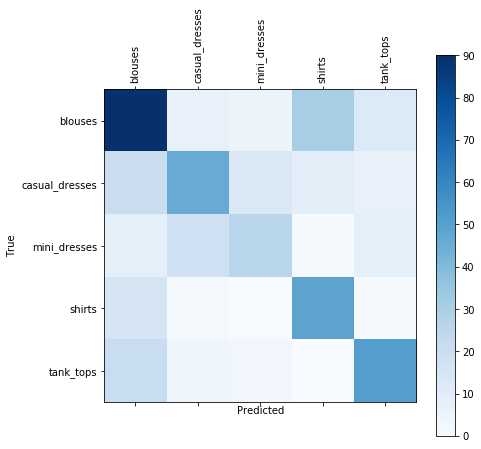

In [17]:
# ===================
# Performance for cc3
# ===================

y_pred_cc3 = pred[0]
y_pred_tags = pred[1]

y_true = data_balanced[3100:]['cc3_le'].values

y_pred_cc3_le = np.argmax(y_pred_cc3, axis=1)

# Useful resources: top 1, top 2, top k accuracy.
# # meaning of top-1, top-5: https://stackoverflow.com/questions/37668902/evaluation-calculate-top-n-accuracy-top-1-and-top-5
# https://stackoverflow.com/questions/44799516/tensorflow-is-there-a-metric-to-calculate-and-update-top-k-accuracy 
# https://www.tensorflow.org/api_docs/python/tf/math/in_top_k?version=stable

top1 = tf.keras.backend.mean(tf.math.in_top_k(predictions=y_pred_cc3, targets=y_true, k=1)).numpy()
top2 = tf.keras.backend.mean(tf.math.in_top_k(predictions=y_pred_cc3, targets=y_true, k=2)).numpy()
top5 = tf.keras.backend.mean(tf.math.in_top_k(predictions=y_pred_cc3, targets=y_true, k=5)).numpy()

print('top1, top2, top5 accuracies on the test set: ', top1, top2, top5)
print()
print('classification_report:')
print()
print(classification_report(y_true, y_pred_cc3_le))
print()
print('Confusion matrix:')

labels = columns_cc3
cm=confusion_matrix(y_true,y_pred_cc3_le)
print(cm)

fig = plt.figure(1,(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap='Blues')
#plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels, rotation=90)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("./model_training/tf_keras_model/confusion_matrix_cc3.png", format="png")
plt.show()

Tag:  color1
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       336
           1       0.63      0.72      0.68       111

    accuracy                           0.83       447
   macro avg       0.77      0.79      0.78       447
weighted avg       0.84      0.83      0.83       447

Tag:  color1
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       341
           1       0.80      0.74      0.76       106

    accuracy                           0.89       447
   macro avg       0.86      0.84      0.85       447
weighted avg       0.89      0.89      0.89       447

Tag:  color1
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       337
           1       0.71      0.68      0.69       110

    accuracy                           0.85       447
   macro avg       0.80      0.79      0.80       447
weighted avg       0.85      0.85  

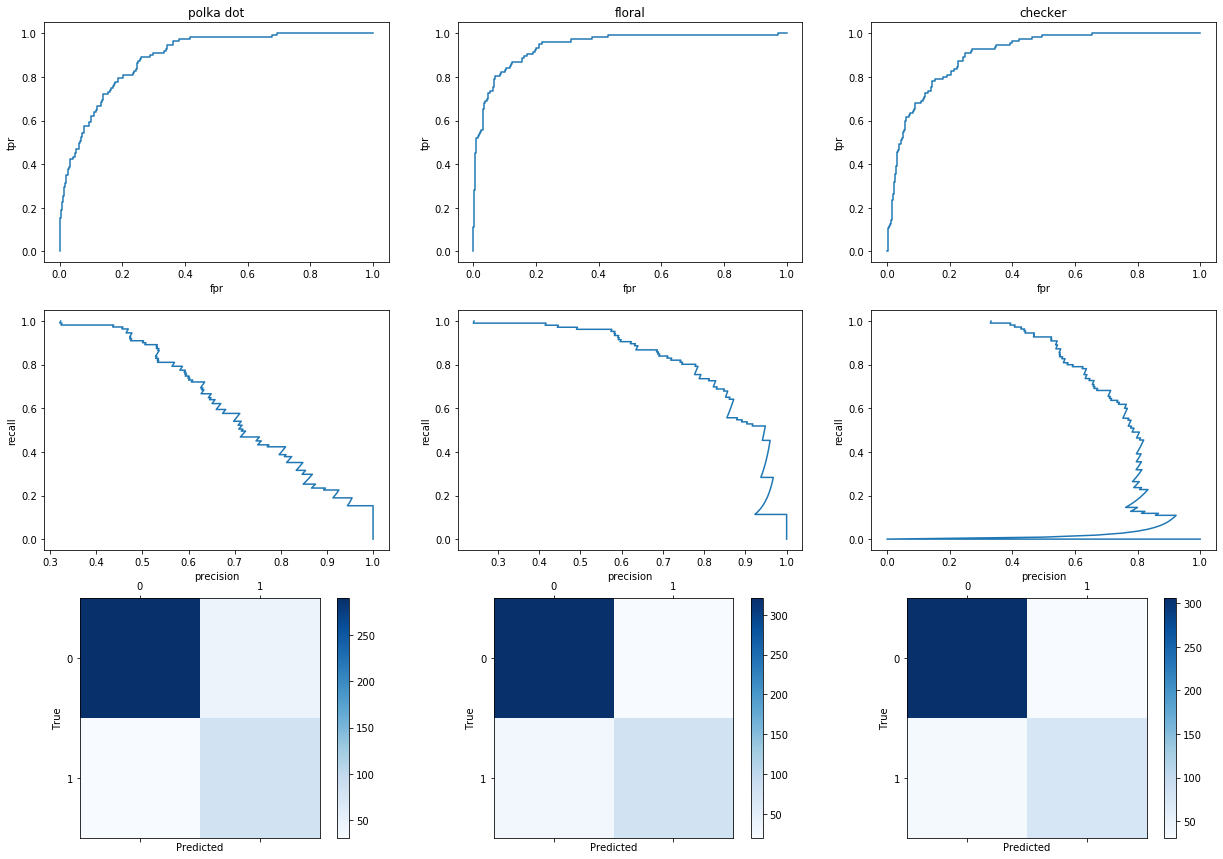

In [19]:
# ====================
# Performance for tags
# ====================

# classification_report
# ---------------------
y_pred_tags_bool = (y_pred_tags > 0.4)
predictions_tags = y_pred_tags_bool.astype(int)

#columns should be the same order of y_col
results_heldout=pd.DataFrame(predictions_tags, columns=columns_tags)
results_heldout['category1'] = np.argsort(y_pred_cc3)[:,-1]
results_heldout['category2'] = np.argsort(y_pred_cc3)[:,-2]
results_heldout['uuid'] = heldout_generator.filenames
ordered_cols=['uuid', 'category1', 'category2']+columns_tags
results_heldout = results_heldout[ordered_cols] #To get the same column order

for column in columns_tags:    
    y_val = data_balanced[3100:][column].values
    y_val_pred = results_heldout[column].values
    print('Tag: ', item)
    print(classification_report(y_val, y_val_pred))

# classification_report
# ---------------------    

fig = plt.figure(1,(21,15))

for i, column in enumerate(columns_tags):
    y_val = data_balanced[3100:][column].values
    y_val_pred = results_heldout[column].values
    
    # ROC curve
    ax = fig.add_subplot(3,3,1+i)
    fpr, tpr, _ = roc_curve(y_val, y_pred_tags[:,i])    
    plt.title(column)
    plt.plot(fpr,tpr)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    
    # PR curve
    ax = fig.add_subplot(3,3,4+i)    
    precision, recall, _ = precision_recall_curve(y_val, y_pred_tags[:,i])  
    plt.plot(precision, recall)
    plt.xlabel('precision')
    plt.ylabel('recall')    
    
    # Confusion matrix
    ax = fig.add_subplot(3,3,7+i)
    cm=confusion_matrix(y_val,predictions_tags[:,i])
    print(cm)    
    cax = ax.matshow(cm, cmap='Blues')    
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('True')  
    
plt.savefig("./model_training/tf_keras_model/confusion_matrix_tags.png", format="png")    
plt.show()     

In [141]:
# ============================
# Serving on inference dataset
# ============================

inference_generator.reset()
pred=model.predict_generator(inference_generator,
                             steps=STEP_SIZE_INFERENCE,
                             verbose=1)

429/429 [==============================] - 8s 18ms/step


In [142]:
y_pred_cc3 = pred[0]
y_pred_tags = pred[1]

y_pred_tags_bool = (y_pred_tags > 0.4)
predictions_tags = y_pred_tags_bool.astype(int)

#columns should be the same order of y_col
results_inference=pd.DataFrame(predictions_tags, columns=columns_tags)
results_inference['category1'] = np.argsort(y_pred_cc3)[:,-1]
results_inference['category2'] = np.argsort(y_pred_cc3)[:,-2]
results_inference['uuid'] = inference_generator.filenames
ordered_cols=['uuid', 'category1', 'category2']+columns_tags
results_inference = results_inference[ordered_cols] #To get the same column order

le = le_dico['cc3']

results_inference['category1_name'] = le.inverse_transform(results_inference['category1'].values)
results_inference['category2_name'] = le.inverse_transform(results_inference['category2'].values)
results_inference.head(10)

uuid  category1  category2  polka dot  \
0  01214_HahXniyBFwRjdgv1Z2GtTN4y.jpeg          0          4          0   
1  005ce_nRriUxiS8iyLBW5ipdem5CrA.jpeg          2          4          0   
2  020b8_1um37vo4nagrTUrPaMnvhXbK.jpeg          4          1          0   
3  033cd_7e58vR1T9vW2R7pnSDNUhLoK.jpeg          2          1          0   
4  00f4a_ntveDEhQknB7cohthb4eeHd8.jpeg          4          2          1   
5  01e0f_GY1KqT78HX9QUfr5F57jS5X9.jpeg          0          2          0   
6  01284_xCbmAarz3uGwiVtQ5mH2yK8A.jpeg          3          0          0   
7  02272_GN1wPQpKYsFFZsDFtwWPCv1U.jpeg          0          4          0   
8  03729_kfj8vTFTD9rLDd41ZCMAg9ui.jpeg          3          0          0   
9  04240_xtwFEMnzhynRpojGWjfEus4f.jpeg          0          3          0   

   floral  checker category1_name  category2_name  
0       0        0        BLOUSES       TANK_TOPS  
1       0        0   MINI_DRESSES       TANK_TOPS  
2       0        1      TANK_TOPS  CASUAL_DRESSES  
3       1        0   MINI_DRESSES  CASUAL_DRESSES  
4       0        0      TANK_TOPS    MINI_DRESSES  
5       1        0        BLOUSES    MINI_DRESSES  
6       0        1         SHIRTS         BLOUSES  
7       1        0        BLOUSES       TANK_TOPS  
8       0        1         SHIRTS         BLOUSES  
9       0        0        BLOUSES          SHIRTS

In [144]:
table = pa.Table.from_pandas(results_inference)
pq.write_table(table, 'predictions_model2.parquet')

# 3. Serving the model using TF-SERVING

In [15]:
# Relevant documentation: 
# https://medium.com/tensorflow/training-and-serving-ml-models-with-tf-keras-fd975cc0fa27
# https://hackernoon.com/how-we-improved-tensorflow-serving-performance-by-over-70-f21b5dad2d98
# https://towardsdatascience.com/deploying-kaggle-solution-with-tensorflow-serving-part-1-of-2-803391c9648
# interesting: https://medium.com/data-science-engineering/productising-tensorflow-keras-models-via-tensorflow-serving-69e191cb1f37

In [146]:
# ==============================================
# Saving the tf.keras model as a .pb saved_model
# ==============================================

# relevant links:
# https://www.tensorflow.org/tutorials/keras/save_and_load
# https://medium.com/tensorflow/training-and-serving-ml-models-with-tf-keras-fd975cc0fa27

# First load the saved tf.keras model (so that no need to run model part before)

# model 1 (model input image height x width: 301x217)
#model = load_model('./model_training/tf_keras_model_1/model-epoch09-cc3_loss1.2428-tags_loss0.2830-val_cc3_acc0.52-val_tags_acc0.88.h5')

# model 2 (model input image height x width: 224x224)
model = load_model('./model_training/tf_keras_model_2/model-epoch32-cc3_loss1.1084-tags_loss0.3010-val_cc3_acc0.59-val_tags_acc0.89.h5')

# Saving the model to a pb (protobuffer) file for TF-SERVING
model.save('model_training/saved_model/my_model/2/') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_training/saved_model/my_model/2/assets


In [147]:
# Inspection of the tree
!tree $(pwd)/model_training/saved_model

/home/philippe/Documents/github/Vinted_exercise/model_training/saved_model
└── my_model
    ├── 1
    │   ├── assets
    │   ├── saved_model.pb
    │   └── variables
    │       ├── variables.data-00000-of-00002
    │       ├── variables.data-00001-of-00002
    │       └── variables.index
    └── 2
        ├── assets
        ├── saved_model.pb
        └── variables
            ├── variables.data-00000-of-00002
            ├── variables.data-00001-of-00002
            └── variables.index

7 directories, 8 files


In [148]:
# Inspection of the saved model. Very handy way to check that the dimensions and names of the outputs are ok
!saved_model_cli show --dir $(pwd)/model_training/saved_model/my_model/2/ --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['cc3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
    outputs['tags'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:1
  Method name is: tensorflow/serving/predict


In [149]:
# Useful resources for TF serving:
# https://www.tensorflow.org/guide/saved_model 
# https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# Notes: How to install tf serving (ubuntu)
# https://www.tensorflow.org/tfx/serving/setup
# https://www.tensorflow.org/tfx/tutorials/serving/rest_simple
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -
# sudo apt-get update
# sudo apt-get install tensorflow-model-server

In [72]:
# ==============================================
# Hosting a model server with TensorFlow Serving
# ==============================================

# Please launch the following command in a terminal, in the same folder of this notebook! This will launch the server hosting the model, and listening to requests:

# tensorflow_model_server --model_base_path=$(pwd)/model_training/saved_model/my_model/ --rest_api_port=9000 --model_name=my_model

{
    "predictions": [
        {
            "tags": [0.885573089, 0.118032426, 0.0285593942],
            "cc3": [0.208780676, 0.231202543, 0.455193877, 0.081572935, 0.0232499149]
        }
    ]
}
Raw prediction:  {'tags': [0.885573089, 0.118032426, 0.0285593942], 'cc3': [0.208780676, 0.231202543, 0.455193877, 0.081572935, 0.0232499149]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['polka dot']


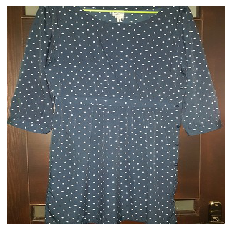

In [151]:
# ======================================
# Example of serving on a single picture
# ======================================

#file = './data/00a5f_ozkvtHQfYePXmFMPyBjWao97.jpeg'
#file = './data/02acd_vP63wx1pq9avpoLptz47kd7r.jpeg'
file = './data/0436c_3UNwTkvQBb5qS8A7ENmuVkiJ.jpeg'
img = tf.keras.preprocessing.image.load_img(file, target_size=[height,width])

plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img) / 255. 
#x = tf.image.convert_image_dtype(x, tf.float16)
x = x[tf.newaxis,...]
x = x.astype(np.float16)
#x = tf.dtypes.cast(x, tf.float16)

data = json.dumps({"signature_name": "serving_default","instances": x.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:9000/v1/models/my_model:predict',
                              data=data, headers=headers)
print(json_response.text)
predictions = np.array(json.loads(json_response.text)["predictions"])[0]
print('Raw prediction: ', predictions)

# Getting 2 highest probability indices for cc3
ind_cc3 = heapq.nlargest(2, range(len(predictions['cc3'])), predictions['cc3'].__getitem__) 
print('cc3:', [columns_cc3[item] for item in ind_cc3])

# Getting indices of tags for which probability > 0.5
ind_tags = [i for i, x in enumerate(predictions['tags']) if x>0.4]
print('tags:', [columns_tags[item] for item in ind_tags])

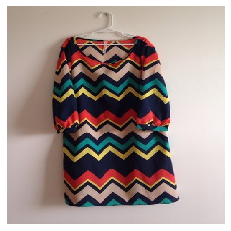

File:  ./data/01214_HahXniyBFwRjdgv1Z2GtTN4y.jpeg
Raw prediction:  {'tags': [0.00153744349, 0.00375068211, 0.0324145034], 'cc3': [0.662278473, 0.0591198392, 0.0285647213, 0.0761335343, 0.173903376]}
cc3: ['blouses', 'tank_tops']
tags: []




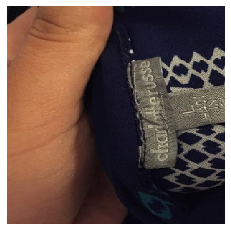

File:  ./data/005ce_nRriUxiS8iyLBW5ipdem5CrA.jpeg
Raw prediction:  {'tags': [0.384565532, 0.0967152342, 0.0438117757], 'cc3': [0.0427768752, 0.109580912, 0.579873621, 0.0249340106, 0.242834553]}
cc3: ['mini_dresses', 'tank_tops']
tags: []




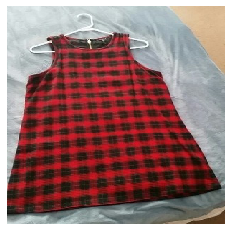

File:  ./data/020b8_1um37vo4nagrTUrPaMnvhXbK.jpeg
Raw prediction:  {'tags': [0.321351081, 0.0118776299, 0.493667305], 'cc3': [0.0947378054, 0.272546083, 0.182897761, 0.083707355, 0.366110951]}
cc3: ['tank_tops', 'casual_dresses']
tags: ['checker']




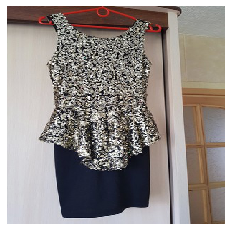

File:  ./data/033cd_7e58vR1T9vW2R7pnSDNUhLoK.jpeg
Raw prediction:  {'tags': [0.165254802, 0.446778148, 0.0027374588], 'cc3': [0.0854594782, 0.282872856, 0.564443529, 0.00768132322, 0.0595427938]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['floral']




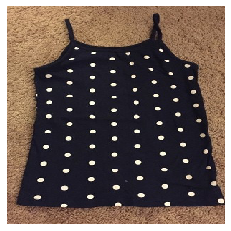

File:  ./data/00f4a_ntveDEhQknB7cohthb4eeHd8.jpeg
Raw prediction:  {'tags': [0.976029336, 0.00329257082, 0.013411127], 'cc3': [0.0140715661, 0.0263006575, 0.0543194748, 0.00404028688, 0.901268]}
cc3: ['tank_tops', 'mini_dresses']
tags: ['polka dot']




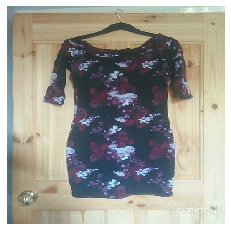

File:  ./data/01e0f_GY1KqT78HX9QUfr5F57jS5X9.jpeg
Raw prediction:  {'tags': [0.0298298895, 0.732085347, 0.00592273334], 'cc3': [0.708783448, 0.0801031291, 0.103074782, 0.080810979, 0.027227629]}
cc3: ['blouses', 'mini_dresses']
tags: ['floral']




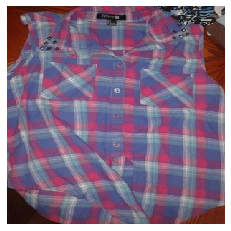

File:  ./data/01284_xCbmAarz3uGwiVtQ5mH2yK8A.jpeg
Raw prediction:  {'cc3': [0.219375327, 0.0230121929, 0.0147552062, 0.697430253, 0.0454270318], 'tags': [0.04555244, 0.0185120199, 0.472799659]}
cc3: ['shirts', 'blouses']
tags: ['checker']




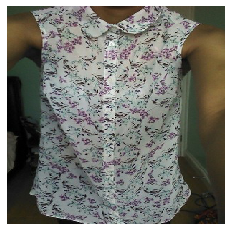

File:  ./data/02272_GN1wPQpKYsFFZsDFtwWPCv1U.jpeg
Raw prediction:  {'tags': [0.103210837, 0.654404342, 0.00380829652], 'cc3': [0.512474298, 0.0423897021, 0.0389710963, 0.0190685503, 0.387096345]}
cc3: ['blouses', 'tank_tops']
tags: ['floral']




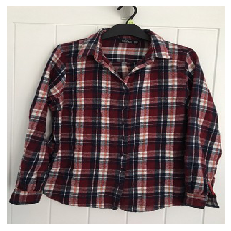

File:  ./data/03729_kfj8vTFTD9rLDd41ZCMAg9ui.jpeg
Raw prediction:  {'tags': [0.00720697641, 0.000999216456, 0.933281362], 'cc3': [0.124474674, 0.00495728, 0.0025782052, 0.867196798, 0.000792991603]}
cc3: ['shirts', 'blouses']
tags: ['checker']




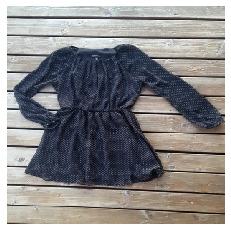

File:  ./data/04240_xtwFEMnzhynRpojGWjfEus4f.jpeg
Raw prediction:  {'tags': [0.316491932, 0.186601162, 0.177276641], 'cc3': [0.416277647, 0.145879462, 0.175951481, 0.217957392, 0.0439340547]}
cc3: ['blouses', 'shirts']
tags: []




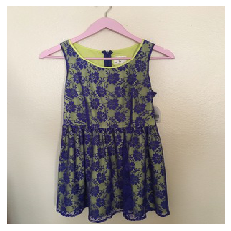

File:  ./data/01ec5_YNqEBKnyoLsKz2SVnW8tLHYy.jpeg
Raw prediction:  {'tags': [0.105050564, 0.798162341, 0.0152412048], 'cc3': [0.00637398474, 0.370872378, 0.198002964, 0.000229156183, 0.424521416]}
cc3: ['tank_tops', 'casual_dresses']
tags: ['floral']




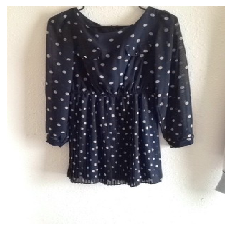

File:  ./data/018cd_F9Dg84vAB1XvtwRtnUxfJ4Ya.jpeg
Raw prediction:  {'tags': [0.464560717, 0.276125848, 0.0444741063], 'cc3': [0.63335371, 0.137479052, 0.161004677, 0.06077924, 0.00738338381]}
cc3: ['blouses', 'mini_dresses']
tags: ['polka dot']




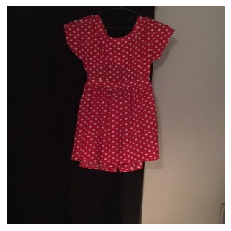

File:  ./data/00039_wGiQHhRXTpJeLgWhVcHNUCAz.jpeg
Raw prediction:  {'tags': [0.901315689, 0.0295528136, 0.0614245199], 'cc3': [0.0364207923, 0.39618662, 0.40160659, 0.0139944283, 0.151791602]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['polka dot']




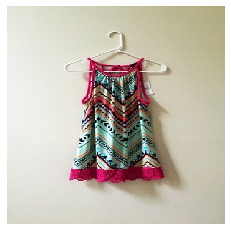

File:  ./data/01fc3_i6xADk4iDhBNgKMUsbGnAJNp.jpeg
Raw prediction:  {'cc3': [0.0387220569, 0.190916687, 0.260478228, 0.000782561663, 0.509100497], 'tags': [0.0450547226, 0.673192263, 0.0210032929]}
cc3: ['tank_tops', 'mini_dresses']
tags: ['floral']




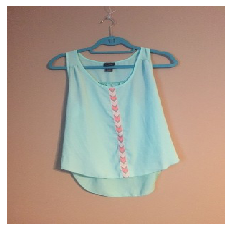

File:  ./data/01a0e_ktikQhVhaH6U97UDHnZPFVe9.jpeg
Raw prediction:  {'cc3': [0.16325812, 0.301392913, 0.099882327, 0.0432053618, 0.392261207], 'tags': [0.551977515, 0.163477585, 0.0480527245]}
cc3: ['tank_tops', 'casual_dresses']
tags: ['polka dot']




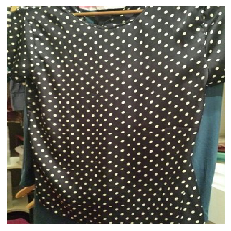

File:  ./data/0069e_resRbhTQb5RRnZdVoPhnF9WD.jpeg
Raw prediction:  {'tags': [0.993508697, 0.0034131729, 0.0178782623], 'cc3': [0.337081134, 0.352300256, 0.178195819, 0.109731473, 0.0226913]}
cc3: ['casual_dresses', 'blouses']
tags: ['polka dot']




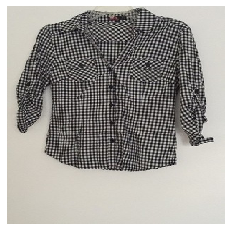

File:  ./data/00c2e_HQekkaVqqs8aA6LVsGxu9z2C.jpeg
Raw prediction:  {'tags': [0.696189404, 0.00347470725, 0.468987256], 'cc3': [0.627102911, 0.0114799095, 0.0280860253, 0.331126928, 0.00220423308]}
cc3: ['blouses', 'shirts']
tags: ['polka dot', 'checker']




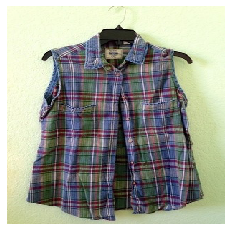

File:  ./data/002aa_HqWaDR4GsA2SCNjyxCxNFp8G.jpeg
Raw prediction:  {'cc3': [0.356979817, 0.132149935, 0.0568688512, 0.302400023, 0.151601434], 'tags': [0.00708731217, 0.0333542302, 0.783003509]}
cc3: ['blouses', 'shirts']
tags: ['checker']




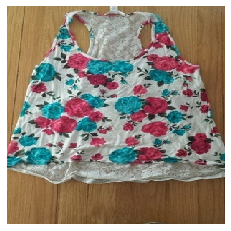

File:  ./data/02054_ZECoJehwvAdJL16nPRdTSCg9.jpeg
Raw prediction:  {'cc3': [0.470180571, 0.0278713536, 0.214585394, 0.11376743, 0.173595309], 'tags': [0.00722698, 0.878370643, 0.0117790252]}
cc3: ['blouses', 'mini_dresses']
tags: ['floral']




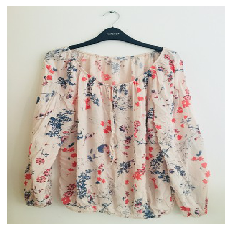

File:  ./data/04440_wvRdux79mncLLWBMEgXhygkW.jpeg
Raw prediction:  {'cc3': [0.702889144, 0.0819972456, 0.0721584558, 0.117766753, 0.025188379], 'tags': [0.25509268, 0.81999, 0.0294261724]}
cc3: ['blouses', 'shirts']
tags: ['floral']




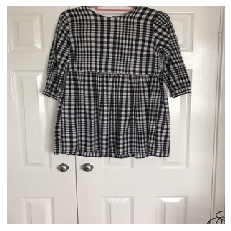

File:  ./data/03a9a_7FnRvUr2J1kaaRSrCUMychK3.jpeg
Raw prediction:  {'tags': [0.167186558, 0.00366154569, 0.631629169], 'cc3': [0.483292967, 0.0667872578, 0.0335254781, 0.410723656, 0.00567066157]}
cc3: ['blouses', 'shirts']
tags: ['checker']




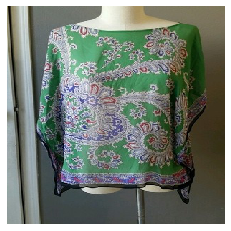

File:  ./data/0049a_JPUyWH7TWdHE87sxGEZDNAdH.jpeg
Raw prediction:  {'cc3': [0.55739224, 0.0293854773, 0.177257702, 0.0684493333, 0.167515203], 'tags': [0.147449195, 0.267067313, 0.00828813668]}
cc3: ['blouses', 'mini_dresses']
tags: []




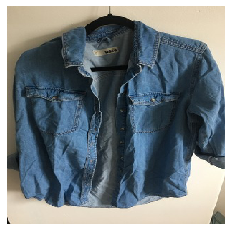

File:  ./data/0332f_14WqgZJJF7i8ReXh8WAUx2Q2.jpeg
Raw prediction:  {'cc3': [0.174395263, 0.00381195988, 0.00519058201, 0.81577909, 0.000823077513], 'tags': [0.0252489261, 0.133303225, 0.182184368]}
cc3: ['shirts', 'blouses']
tags: []




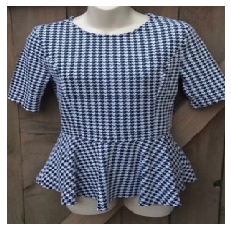

File:  ./data/02abe_P1ZpWHXp3CkrrZzdrnnkU4uS.jpeg
Raw prediction:  {'tags': [0.375912517, 0.00131396472, 0.353383154], 'cc3': [0.572379291, 0.194977179, 0.0612857, 0.158608869, 0.0127489679]}
cc3: ['blouses', 'casual_dresses']
tags: []




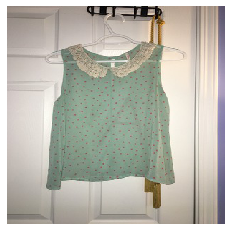

File:  ./data/04b58_zRM75iXqsbaZGJbMiTu2m23v.jpeg
Raw prediction:  {'cc3': [0.0628893152, 0.282511175, 0.0742180273, 0.0278076641, 0.55257374], 'tags': [0.313543767, 0.0799694061, 0.0961081609]}
cc3: ['tank_tops', 'casual_dresses']
tags: []




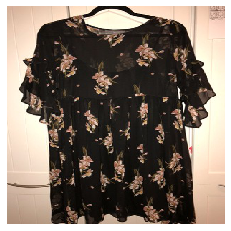

File:  ./data/025e3_k5tFffWF6JFT1FoCNN3CFXFR.jpeg
Raw prediction:  {'tags': [0.0214415677, 0.88323, 0.00306602754], 'cc3': [0.476551145, 0.18530719, 0.176285684, 0.157803521, 0.00405241875]}
cc3: ['blouses', 'casual_dresses']
tags: ['floral']




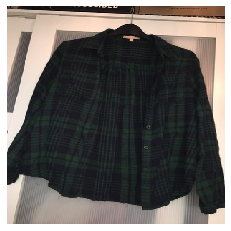

File:  ./data/0477d_LWbCxVJSu3kmVHo18SZHaS5W.jpeg
Raw prediction:  {'cc3': [0.210855544, 0.0195758101, 0.0203034151, 0.741565764, 0.00769950775], 'tags': [0.296863705, 0.0512429364, 0.445310652]}
cc3: ['shirts', 'blouses']
tags: ['checker']




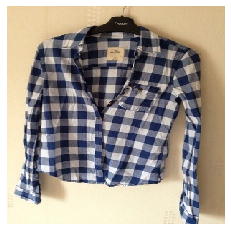

File:  ./data/02473_TQXWauKKoP7CUABQygX3nx9w.jpeg
Raw prediction:  {'tags': [0.00250716438, 0.00404751, 0.920660794], 'cc3': [0.149912119, 0.00734929647, 0.00307288044, 0.838732362, 0.00093339145]}
cc3: ['shirts', 'blouses']
tags: ['checker']




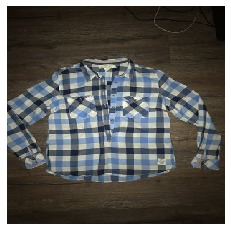

File:  ./data/04cbf_QvUPbGVPAeUm8yUWScPMDexD.jpeg
Raw prediction:  {'tags': [0.00563559867, 0.00728334533, 0.89413631], 'cc3': [0.193036437, 0.00861681346, 0.0101224454, 0.778938115, 0.00928621553]}
cc3: ['shirts', 'blouses']
tags: ['checker']




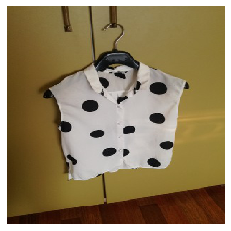

File:  ./data/02641_yvJuwvhrWKuj4NYeDbQLsbk5.jpeg
Raw prediction:  {'tags': [0.496526212, 0.155036375, 0.110504948], 'cc3': [0.568518817, 0.0111359525, 0.0231108423, 0.0651472285, 0.332087129]}
cc3: ['blouses', 'tank_tops']
tags: ['polka dot']




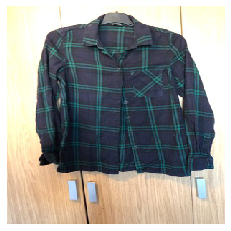

File:  ./data/03eb8_DSv8V4DMW1iY5gdSn41JcK5W.jpeg
Raw prediction:  {'cc3': [0.145633072, 0.00619629677, 0.00265538925, 0.842873216, 0.00264196121], 'tags': [0.0135684274, 0.00666666077, 0.941892564]}
cc3: ['shirts', 'blouses']
tags: ['checker']




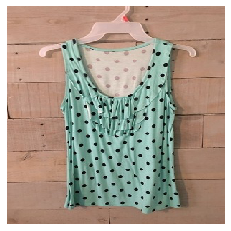

File:  ./data/01373_55JR3dXAn726mZvAssinLwu4.jpeg
Raw prediction:  {'tags': [0.319300562, 0.316788614, 0.00338837551], 'cc3': [0.0374611318, 0.107538186, 0.0585038476, 0.00033271595, 0.796164095]}
cc3: ['tank_tops', 'casual_dresses']
tags: []




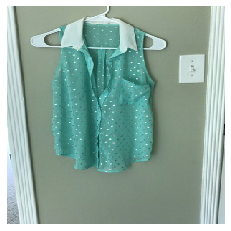

File:  ./data/00f83_1nLu7kQZnUvqyA3MzguVoYbV.jpeg
Raw prediction:  {'tags': [0.364856809, 0.184833, 0.0662139878], 'cc3': [0.0890261456, 0.32271558, 0.36079827, 0.063562572, 0.16389747]}
cc3: ['mini_dresses', 'casual_dresses']
tags: []




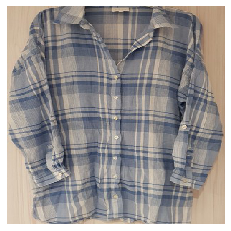

File:  ./data/03eba_qhLBHC5bZp9ngT183k5tfBLv.jpeg
Raw prediction:  {'tags': [0.00146636413, 0.00352721079, 0.988923728], 'cc3': [0.171350151, 0.0048567811, 0.000760802883, 0.82190311, 0.00112907763]}
cc3: ['shirts', 'blouses']
tags: ['checker']




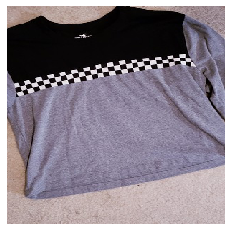

File:  ./data/03fc2_Hi7thDaCFDGz6foBBHKdcKbY.jpeg
Raw prediction:  {'tags': [0.169898689, 0.0769156441, 0.0581021495], 'cc3': [0.462350428, 0.0521084107, 0.088873595, 0.104349181, 0.292318374]}
cc3: ['blouses', 'tank_tops']
tags: []




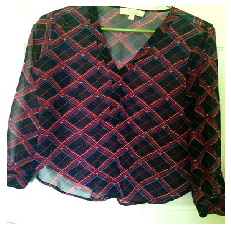

File:  ./data/006a2_SiahAnL18pWNVzb4cbB6RL8w.jpeg
Raw prediction:  {'tags': [0.0540248, 0.00400603702, 0.709368587], 'cc3': [0.617101908, 0.0139975632, 0.00683654752, 0.358972788, 0.00309118186]}
cc3: ['blouses', 'shirts']
tags: ['checker']




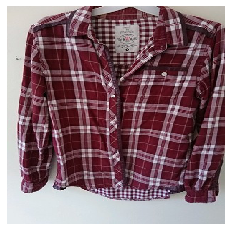

File:  ./data/02611_B5boEBY17LS9zx7Xc2vLPhHh.jpeg
Raw prediction:  {'tags': [0.00794371124, 0.00252391631, 0.94242692], 'cc3': [0.239380211, 0.0107917488, 0.00218112534, 0.746020317, 0.00162667257]}
cc3: ['shirts', 'blouses']
tags: ['checker']




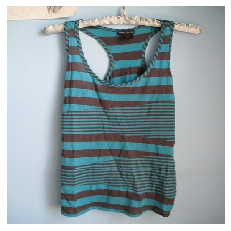

File:  ./data/00d95_W4dHv9LbkdaGKpjy8PZobKMD.jpeg
Raw prediction:  {'tags': [0.0600427687, 0.0214567501, 0.0380360186], 'cc3': [0.042284891, 0.0576120913, 0.0502297692, 0.0115152746, 0.838357925]}
cc3: ['tank_tops', 'casual_dresses']
tags: []




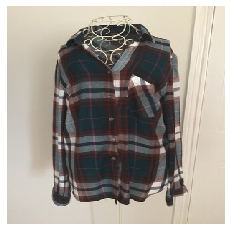

File:  ./data/04db7_FLzMNtVDq7D6aFBhXoQBkY7H.jpeg
Raw prediction:  {'cc3': [0.283964783, 0.0136136338, 0.00708904536, 0.662444353, 0.0328882374], 'tags': [0.00338063273, 0.0622887462, 0.300700456]}
cc3: ['shirts', 'blouses']
tags: []




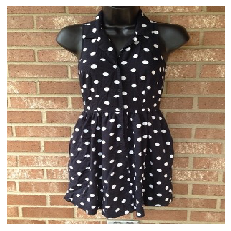

File:  ./data/01215_1oYxWozgf5wFo3ftN7pFEeAS.jpeg
Raw prediction:  {'tags': [0.671216547, 0.0488012619, 0.0199177824], 'cc3': [0.0392313972, 0.412813962, 0.508720815, 0.0171268769, 0.0221069623]}
cc3: ['mini_dresses', 'casual_dresses']
tags: ['polka dot']




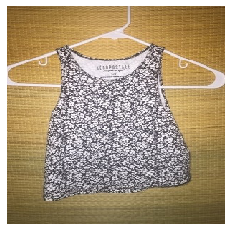

File:  ./data/01edf_d1FYt6MVikBFnpu2SMXzGJ4D.jpeg
Raw prediction:  {'tags': [0.105796173, 0.55366528, 0.00393267535], 'cc3': [0.0755955502, 0.0148267858, 0.0854529217, 0.00153925747, 0.822585464]}
cc3: ['tank_tops', 'mini_dresses']
tags: ['floral']




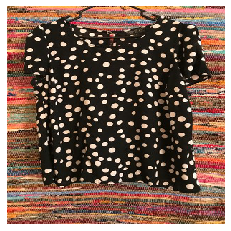

File:  ./data/014f7_D6HtsYdSAwwzZie7PGVvENaS.jpeg
Raw prediction:  {'tags': [0.748855531, 0.0242693312, 0.0172545221], 'cc3': [0.658556044, 0.0316853486, 0.0797070041, 0.139807597, 0.0902440399]}
cc3: ['blouses', 'shirts']
tags: ['polka dot']




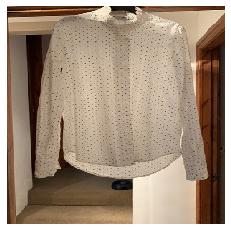

File:  ./data/02781_e76D52Ax8WjucyKNPqbFCqo9.jpeg
Raw prediction:  {'tags': [0.779856324, 0.0191024374, 0.133717895], 'cc3': [0.501753449, 0.0582192279, 0.131358638, 0.235414252, 0.073254481]}
cc3: ['blouses', 'shirts']
tags: ['polka dot']




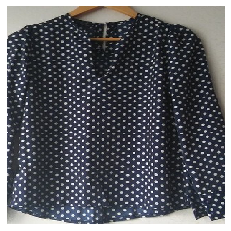

File:  ./data/011f3_cUzy2Lvuxdu5BcruDpXixk7K.jpeg
Raw prediction:  {'cc3': [0.590502501, 0.00600806251, 0.0128803169, 0.38501811, 0.0055909995], 'tags': [0.980914354, 0.00151448429, 0.0552173182]}
cc3: ['blouses', 'shirts']
tags: ['polka dot']




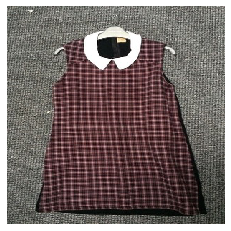

File:  ./data/009c5_hqxem5yuNUXUhJ4X6NXRT5U7.jpeg
Raw prediction:  {'cc3': [0.25988996, 0.127982914, 0.0788505897, 0.470495582, 0.0627809167], 'tags': [0.29131, 0.00227665459, 0.648613811]}
cc3: ['shirts', 'blouses']
tags: ['checker']




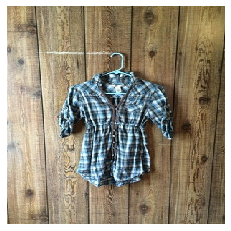

File:  ./data/02000_GuTpdcFXXBPvWg7LxExFcbz1.jpeg
Raw prediction:  {'tags': [0.0118677616, 0.278575838, 0.335871816], 'cc3': [0.486720473, 0.0469661, 0.0470473506, 0.40408656, 0.0151794758]}
cc3: ['blouses', 'shirts']
tags: []




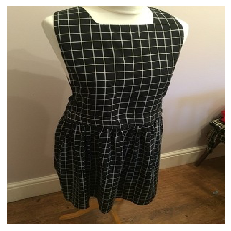

File:  ./data/01d49_4rTvjm61g8Dns89F1PFAGGux.jpeg
Raw prediction:  {'tags': [0.0385658555, 0.0285725333, 0.583050191], 'cc3': [0.0436961055, 0.604172885, 0.312798649, 0.0144954612, 0.0248369295]}
cc3: ['casual_dresses', 'mini_dresses']
tags: ['checker']




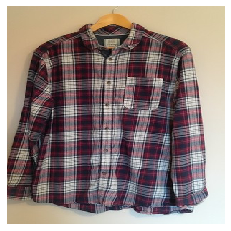

File:  ./data/03ace_EuJbgexZbjRCCrx4zUiekbxV.jpeg
Raw prediction:  {'tags': [0.00519257924, 0.00799665228, 0.934707403], 'cc3': [0.329477727, 0.00386019, 0.00292615476, 0.661271334, 0.00246454193]}
cc3: ['shirts', 'blouses']
tags: ['checker']




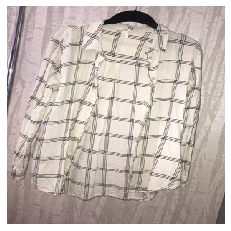

File:  ./data/02e79_pH3zNroMzXcYCMq8HhJTgC6g.jpeg
Raw prediction:  {'tags': [0.0551510267, 0.043436572, 0.607149422], 'cc3': [0.403226554, 0.107969232, 0.0249602348, 0.4321796, 0.0316644423]}
cc3: ['shirts', 'blouses']
tags: ['checker']




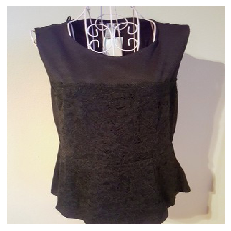

File:  ./data/03640_9qVXNj2tf7cv5YMqBErmxHsf.jpeg
Raw prediction:  {'cc3': [0.313534141, 0.0736849234, 0.117154583, 0.169002086, 0.326624244], 'tags': [0.137242094, 0.110051736, 0.235077098]}
cc3: ['tank_tops', 'blouses']
tags: []




In [155]:
# ========================================
# Example of serving on a list of pictures
# ========================================

for file in test_pd['uuid'][0:50].tolist():
    
    file = './data/{}'.format(file)
    
    img = tf.keras.preprocessing.image.load_img(file, target_size=[height,width])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    x = tf.keras.preprocessing.image.img_to_array(img) / 255. 
    x = x[tf.newaxis,...]

    data = json.dumps({"signature_name": "serving_default","instances": x.tolist()})
    headers = {"content-type": "application/json"}
    json_response = requests.post('http://localhost:9000/v1/models/my_model:predict',
                                  data=data, headers=headers)
    predictions = np.array(json.loads(json_response.text)["predictions"])[0]
    
    print('File: ', file)
    print('Raw prediction: ', predictions)

    # Getting 2 highest probability indices for cc3
    ind_cc3 = heapq.nlargest(2, range(len(predictions['cc3'])), predictions['cc3'].__getitem__) 
    print('cc3:', [columns_cc3[item] for item in ind_cc3])

    # Getting indices of tags for which probability > 0.5
    ind_tags = [i for i, x in enumerate(predictions['tags']) if x>0.4]
    print('tags:', [columns_tags[item] for item in ind_tags])
    print()
    print()